# Compare in-silico with experimental to identify if there are any off-targets and if they are consistent





1 - Difference between in-silico and control 

2 - Difference between depleted and controls

3 - What genes that are not targeted fall off the identity line?

4 - Are those genes predicted through the in-silico analysis?

5 - Are those genes consistent across replicates and can thus be regressed out


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pegasus as pg
import scanpy as sc 
import matplotlib.pyplot as plt
import scipy.sparse
import anndata

from scipy.stats import mannwhitneyu, normaltest
from adjustText import adjust_text
from pandas.api.types import (
    is_numeric_dtype
)
from scipy.stats import rankdata
from statannotations.Annotator import Annotator


/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#read in the 255 protein coding genes targeted with scCLEAN
NVG = pd.read_csv('Tabula_Sapiens_255_analysis/NVG_scCLEAN.csv', header=None)
NVG = list(NVG[0])

MT = pd.read_csv('Tabula_Sapiens_255_analysis/MT_scCLEAN.csv', header=None)
MT = list(MT[0])

Ribo = pd.read_csv('Tabula_Sapiens_255_analysis/Ribo_scCLEAN.csv', header=None)
Ribo = list(Ribo[0])

scclean_genes = NVG+MT+Ribo

# In silico

In [3]:
#insilico depleted versus control, raw counts are bound
ins_d = sc.read_10x_h5('Azimuth_annotations/insilico_depleted_revised.h5')
ins_d.obs_names_make_unique()
ins_d.var_names_make_unique()
sc.pp.filter_cells(ins_d, min_genes=200)
sc.pp.filter_genes(ins_d, min_cells=5)
genes_not_removed = [x for x in list(ins_d.var_names) if x not in scclean_genes]
ins_d = ins_d[:,genes_not_removed]

sc.pp.calculate_qc_metrics(ins_d)
sc.pp.normalize_total(ins_d, target_sum=1e4)
sc.pp.log1p(ins_d, base=2)
sc.pp.highly_variable_genes(ins_d, min_disp = 0.01)

#take the depleted and treat the system as bulk to compare gene expression 
sparse_molecular = ins_d.X
mol_depl = pd.DataFrame.sparse.from_spmatrix(sparse_molecular)
#genes along columns
#average counts across all cells 
mol_depl.loc['mean'] = mol_depl.mean()
mol_depl = mol_depl.T
mol_mean = pd.DataFrame(mol_depl['mean'])
mol_mean['genes'] = ins_d.var.index
mol_mean = mol_mean.set_index('genes')
mol_mean

/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


,mean
genes,
AL627309.1,0.006109
AL627309.3,0.000545
AL627309.5,0.048934
LINC01409,0.214938
FAM87B,0.000962
...,...
AL592183.1,0.533217
AC240274.1,0.026104
AC004556.3,0.102560


In [4]:
#insilico depleted versus control, raw counts are bound
ins_c = sc.read_h5ad('Azimuth_annotations/control_insilico_pbmc.h5ad')
ins_c.obs_names_make_unique()
ins_c.var_names_make_unique()
sc.pp.filter_cells(ins_c, min_genes=200)
sc.pp.filter_genes(ins_c, min_cells=5)
genes_not_removed = [x for x in list(ins_c.var_names) if x not in scclean_genes]
ins_c = ins_c[:,genes_not_removed]

sc.pp.calculate_qc_metrics(ins_c)
sc.pp.normalize_total(ins_c, target_sum=1e4)
sc.pp.log1p(ins_c, base=2)
sc.pp.highly_variable_genes(ins_c, min_disp = 0.01)

#take the depleted and treat the system as bulk to compare gene expression 
sparse_molecular_ctrl = ins_c.X
mol_ctrl = pd.DataFrame.sparse.from_spmatrix(sparse_molecular_ctrl)
#genes along columns
#average counts across all cells 
mol_ctrl.loc['mean'] = mol_ctrl.mean()
mol_ctrl = mol_ctrl.T
ctrl_mean = pd.DataFrame(mol_ctrl['mean'])
ctrl_mean['genes'] = ins_c.var.index
ctrl_mean = ctrl_mean.set_index('genes')
ctrl_mean

/Users/jbezney/miniforge3/envs/pegasus/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


,mean
genes,
AL627309.1,0.006457
AL627309.3,0.000578
AL627309.5,0.047410
LINC01409,0.195512
FAM87B,0.000824
...,...
AL592183.1,0.503535
AC240274.1,0.025368
AC004556.3,0.096366


In [5]:
#merge counts, subtract for log2FC, plot scatter plot 
#create combined DataFrame 
combined = pd.DataFrame()
combined['Insilico'] = mol_mean['mean']
combined['Control'] = ctrl_mean['mean']
combined = combined.dropna()

#the counts are already log2 norm so calc log2FC
combined['Log2FC'] = combined['Insilico'] - combined['Control']
combined = combined.sort_values(by='Log2FC', ascending=False)
combined['gene'] = combined.index
combined

,Insilico,Control,Log2FC,gene
genes,,,,
SLC35F1,2.059898,1.047975,1.011923,SLC35F1
TXNRD1,0.907391,0.607247,0.300144,TXNRD1
AC010894.3,0.718934,0.580702,0.138232,AC010894.3
MTRNR2L12,1.106622,0.992310,0.114312,MTRNR2L12
NBEAL1,0.652223,0.558185,0.094037,NBEAL1
...,...,...,...,...
SERPINA1,0.120057,0.917162,-0.797105,SERPINA1
DBI,0.159768,0.967312,-0.807543,DBI
LINC00486,0.019548,0.893697,-0.874149,LINC00486


/var/folders/fv/spz1kmdd6fzcpgwh4n4pgtxh0000gn/T/ipykernel_24583/1126617632.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles: # adjust legend size


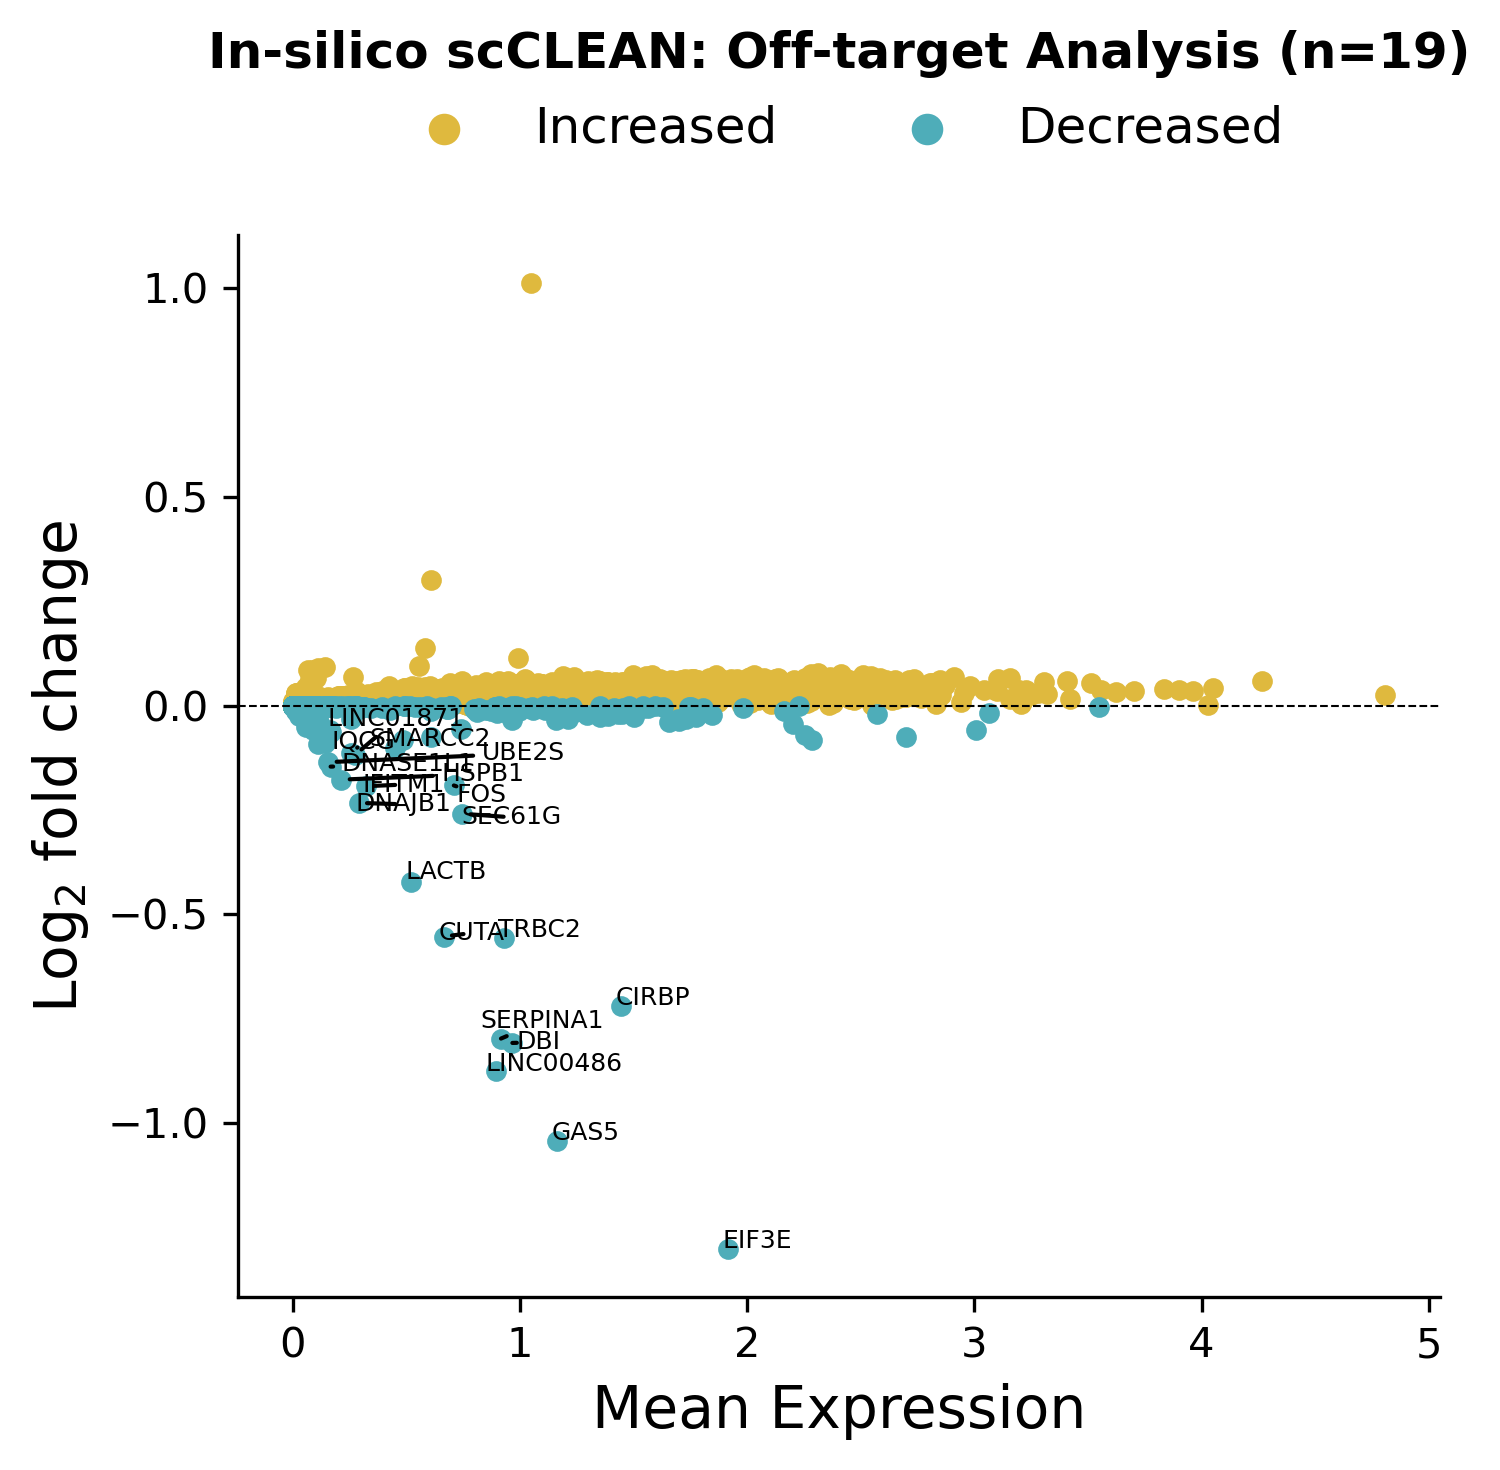

In [6]:
#plot control mean on x-axis, log2FC on y-axis, set threshold, select
from pegasus.plotting.plot_utils import _get_subplot_layouts
fig, ax = _get_subplot_layouts(panel_size=(5, 5), dpi=300)

idx = combined.Log2FC >= 0 
ax.scatter(combined.Control[idx], combined.Log2FC[idx], s=20, 
           c='#DFB93E', marker='o', linewidths=0.5, alpha=1, label="Increased")

idx = combined.Log2FC < 0 
ax.scatter(combined.Control[idx], combined.Log2FC[idx], s=20, 
           c='#4EADB9', marker='o', linewidths=0.5, alpha=1, label="Decreased")

ax.set_xlabel(r"Mean Expression", size=14)
ax.set_ylabel(r"Log$_2$ fold change", size=14)


legend = ax.legend(
        loc="center",
        bbox_to_anchor=(0.5, 1.1),
        frameon=False,
        fontsize=12,
        ncol=4,
    )
for handle in legend.legendHandles: # adjust legend size
    handle.set_sizes([50.0])

ax.axhline(y = 0, c = 'k', lw = 0.5, ls = '--')

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)

#######
texts = []


idx = np.where((combined.Log2FC < -.1)&(combined.Control > 0.1))[0]
posvec = np.argsort(combined.Log2FC[idx])[0:40]
for pos in posvec:
    gid = idx[pos]
    texts.append(ax.text(combined.Control[gid], combined.Log2FC[gid], combined.gene[gid], fontsize=6))
    
from adjustText import adjust_text
adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle='-', color='black', lw=1))

plt.title('In-silico scCLEAN: Off-target Analysis (n='+str(len(texts))+')', fontweight="bold", size=12, pad=40)
plt.tight_layout()
plt.savefig('PBMC_offtarget_analysis/Insilico_offtarget_gene_selection.png', dpi=300)
plt.show()


/var/folders/fv/spz1kmdd6fzcpgwh4n4pgtxh0000gn/T/ipykernel_24583/2287489413.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles: # adjust legend size


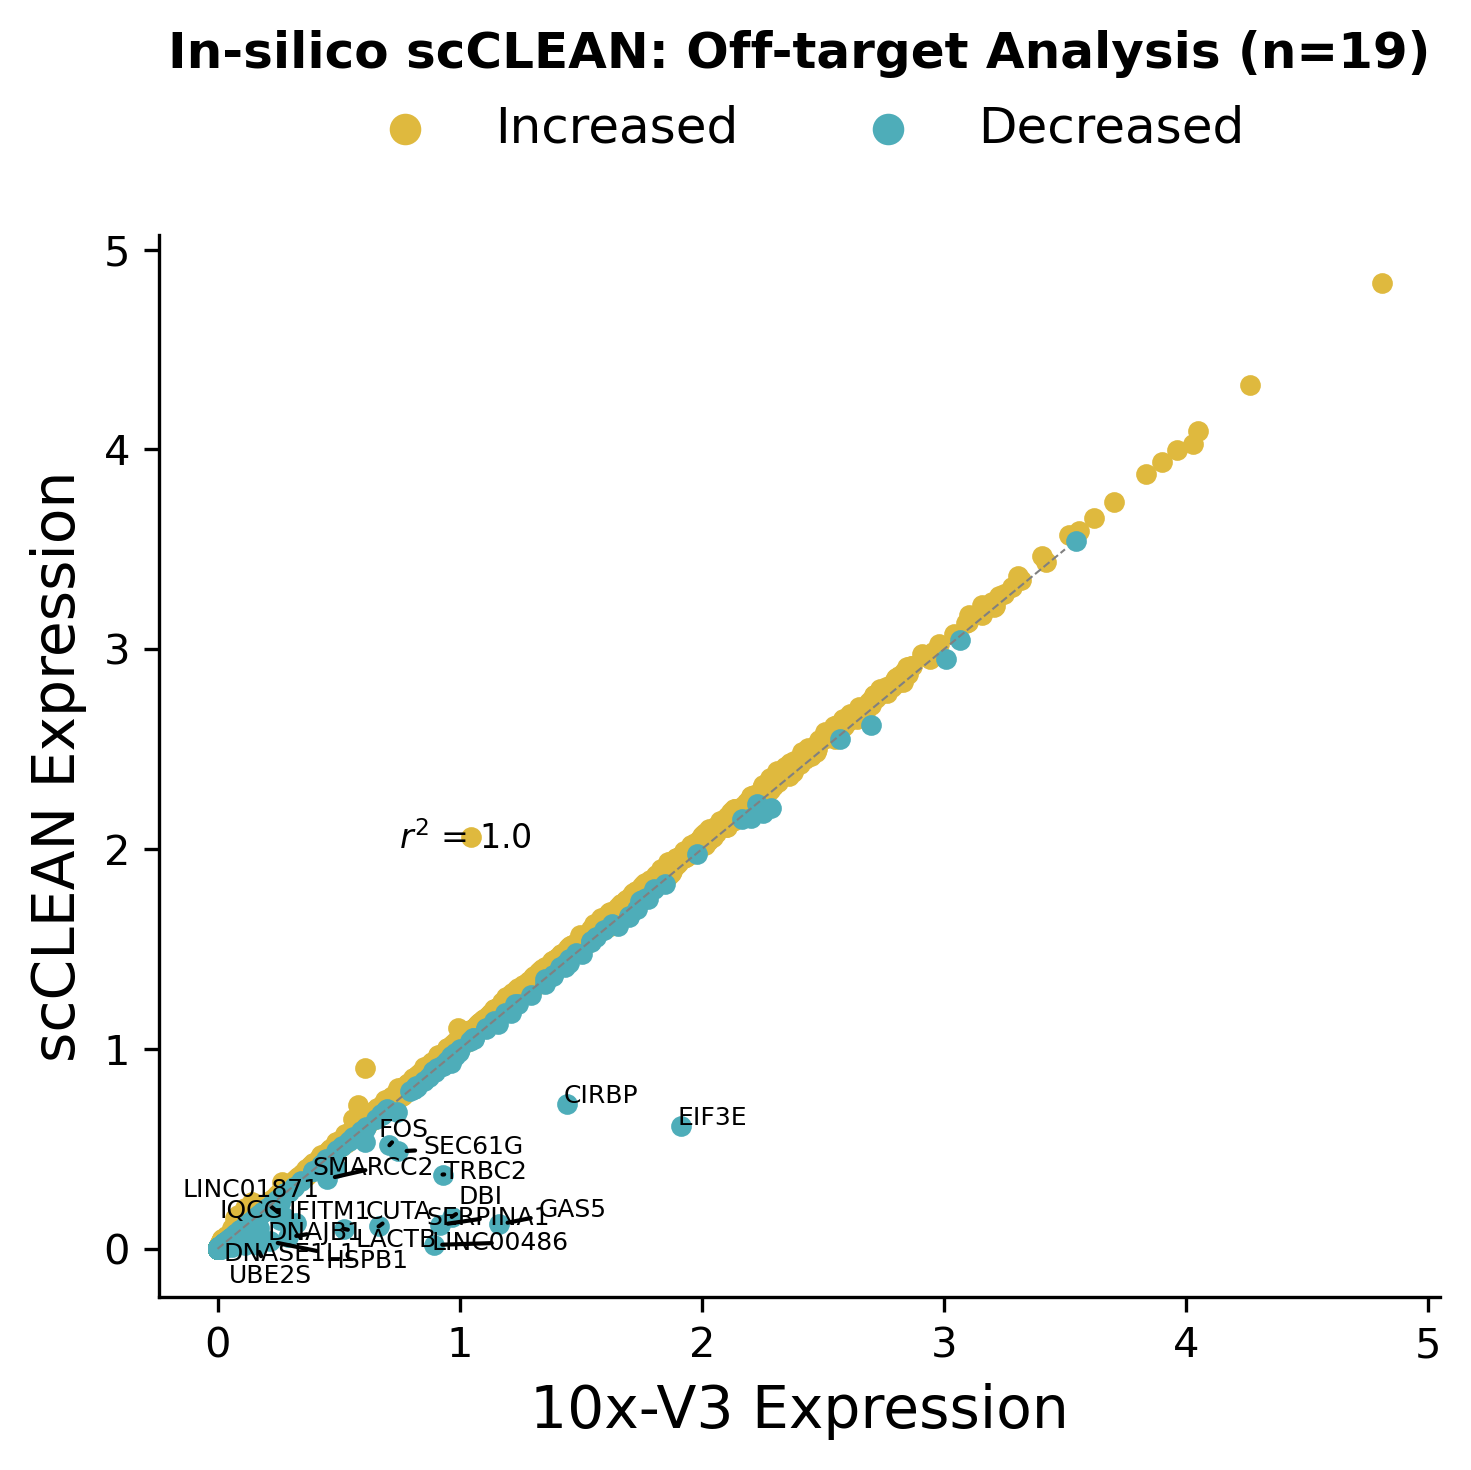

In [7]:
#plot control mean on x-axis, log2FC on y-axis, set threshold, select
from pegasus.plotting.plot_utils import _get_subplot_layouts
fig, ax = _get_subplot_layouts(panel_size=(5, 5), dpi=300)

idx = combined.Log2FC >= 0 
ax.scatter(combined.Control[idx], combined.Insilico[idx], s=20, 
           c='#DFB93E', marker='o', linewidths=0.5, alpha=1, label="Increased")

idx = combined.Log2FC < 0 
ax.scatter(combined.Control[idx], combined.Insilico[idx], s=20, 
           c='#4EADB9', marker='o', linewidths=0.5, alpha=1, label="Decreased")

ax.set_xlabel(r"10x-V3 Expression", size=14)
ax.set_ylabel(r"scCLEAN Expression", size=14)


legend = ax.legend(
        loc="center",
        bbox_to_anchor=(0.5, 1.1),
        frameon=False,
        fontsize=12,
        ncol=4,
    )
for handle in legend.legendHandles: # adjust legend size
    handle.set_sizes([50.0])

ax.plot([0, 3.5], [0, 3.5], color='grey', linestyle='dashed', linewidth=0.5)

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)

######
x= list(combined.Control)
y= list(combined.Insilico)

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r2 = str(round(r_squared, 2))
plt.text(0.75, 2, "$r^2$ = " + r2, fontsize = 8)

#######
texts = []


idx = np.where((combined.Log2FC < -0.1)&(combined.Control > 0.1))[0]
posvec = np.argsort(combined.Log2FC[idx])[0:40]
for pos in posvec:
    gid = idx[pos]
    texts.append(ax.text(combined.Control[gid], combined.Insilico[gid], combined.gene[gid], fontsize=6))
    
from adjustText import adjust_text
adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle='-', color='black', lw=1))

plt.title('In-silico scCLEAN: Off-target Analysis (n='+str(len(texts))+')', fontweight="bold", size=12, pad=40)
plt.tight_layout()
plt.savefig('PBMC_offtarget_analysis/Insilico_offtarget_gene_comparison_r2.png', dpi=300)
plt.show()

In [8]:
#there are 19 genes labeled as off-targets from the in-silico analysis
#notice this is a very conservative estimate of 'off-target'
insilico_decreased = combined[(combined.Log2FC < -0.1)&(combined.Control > 0.1)]
print("There are "+str(len(insilico_decreased))+" genes whose reads were removed scCLEAN guides")
insilico_decreased = list(insilico_decreased.gene)
insilico_decreased

There are 19 genes whose reads were removed scCLEAN guides


['SMARCC2',
 'IQCG',
 'LINC01871',
 'UBE2S',
 'DNASE1L1',
 'HSPB1',
 'FOS',
 'IFITM1',
 'DNAJB1',
 'SEC61G',
 'LACTB',
 'CUTA',
 'TRBC2',
 'CIRBP',
 'SERPINA1',
 'DBI',
 'LINC00486',
 'GAS5',
 'EIF3E']

experimental samples
-

in this case we want to show the 255 targeted genes 

and overlay the potential off-targets 

as well as highlight the off-targets predicted from the in-silico depletion

In [10]:
#do this for experimental scCLEAN samples
std = sc.read_10x_h5('raw_files/FUll_transcriptome/Control_not_masked_filtered_feature_bc_matrix.h5ad')
std.obs_names_make_unique()
std.var_names_make_unique()
sc.pp.filter_cells(std, min_genes=200)
sc.pp.filter_genes(std, min_cells=5)
#genes_not_removed = [x for x in list(std.var_names) if x not in scclean_genes]
#std = std[:,genes_not_removed]

sc.pp.calculate_qc_metrics(std)
sc.pp.normalize_total(std, target_sum=1e4)
sc.pp.log1p(std, base=2)
sc.pp.highly_variable_genes(std, min_disp = 0.01)

#take the depleted and treat the system as bulk to compare gene expression 
sparse_molecular_std = std.X
mol_std = pd.DataFrame.sparse.from_spmatrix(sparse_molecular_std)
#genes along columns
#average counts across all cells 
mol_std.loc['mean'] = mol_std.mean()
mol_std = mol_std.T
std_mean = pd.DataFrame(mol_std['mean'])
std_mean['genes'] = std.var.index
std_mean = std_mean.set_index('genes')
std_mean

ValueError: 'raw_files/FUll_transcriptome/Control_not_masked_filtered_feature_bc_matrix.h5ad' contains more than one genome. For legacy 10x h5 files you must specify the genome if more than one is present. Available genomes are: ['X', 'layers', 'obs', 'obsm', 'obsp', 'uns', 'var', 'varm', 'varp']

In [334]:
#do this for experimental scCLEAN samples
dep = sc.read_10x_h5('raw_files/FUll_transcriptome/Dep_rep3_not_masked_filtered_feature_bc_matrix.h5')
dep.obs_names_make_unique()
dep.var_names_make_unique()
sc.pp.filter_cells(dep, min_genes=200)
sc.pp.filter_genes(dep, min_cells=5)
#genes_not_removed = [x for x in list(dep.var_names) if x not in scclean_genes]
#dep = dep[:,genes_not_removed]

sc.pp.calculate_qc_metrics(dep)
sc.pp.normalize_total(dep, target_sum=1e4)
sc.pp.log1p(dep, base=2)
sc.pp.highly_variable_genes(dep, min_disp = 0.01)

#take the depleted and treat the system as bulk to compare gene expression 
sparse_molecular_dep = dep.X
mol_dep = pd.DataFrame.sparse.from_spmatrix(sparse_molecular_dep)
#genes along columns
#average counts across all cells 
mol_dep.loc['mean'] = mol_dep.mean()
mol_dep = mol_dep.T
dep_mean = pd.DataFrame(mol_dep['mean'])
dep_mean['genes'] = dep.var.index
dep_mean = dep_mean.set_index('genes')
dep_mean

/Users/jbezney/opt/anaconda3/envs/pegasus2/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,mean
genes,
AL627309.1,0.003055
AL627309.5,0.023152
AL627309.4,0.000693
LINC01409,0.078073
FAM87B,0.000690
...,...
AC011043.1,0.004138
AL354822.1,0.030733
AL592183.1,0.080256


In [335]:
#merge counts, subtract for log2FC, plot scatter plot 
#create combined DataFrame 
exp_combined = pd.DataFrame()
exp_combined['scCLEAN'] = dep_mean['mean']
exp_combined['10x-V3'] = std_mean['mean']
exp_combined = exp_combined.dropna()

#the counts are already log2 norm so calc log2FC
exp_combined['Log2FC'] = exp_combined['scCLEAN'] - exp_combined['10x-V3']
exp_combined = exp_combined.sort_values(by='Log2FC', ascending=False)
exp_combined['gene'] = exp_combined.index
exp_combined

,scCLEAN,10x-V3,Log2FC,gene
genes,,,,
PPDPF,2.106944,1.138863,0.968080,PPDPF
TMSB10,4.490453,3.591556,0.898896,TMSB10
CD52,2.907447,2.053224,0.854223,CD52
SON,2.132119,1.293881,0.838239,SON
OST4,2.407007,1.575598,0.831409,OST4
...,...,...,...,...
MT-CO1,0.453873,4.531225,-4.077352,MT-CO1
RPS12,0.091898,4.182890,-4.090992,RPS12
RPS27,0.169096,4.263186,-4.094090,RPS27


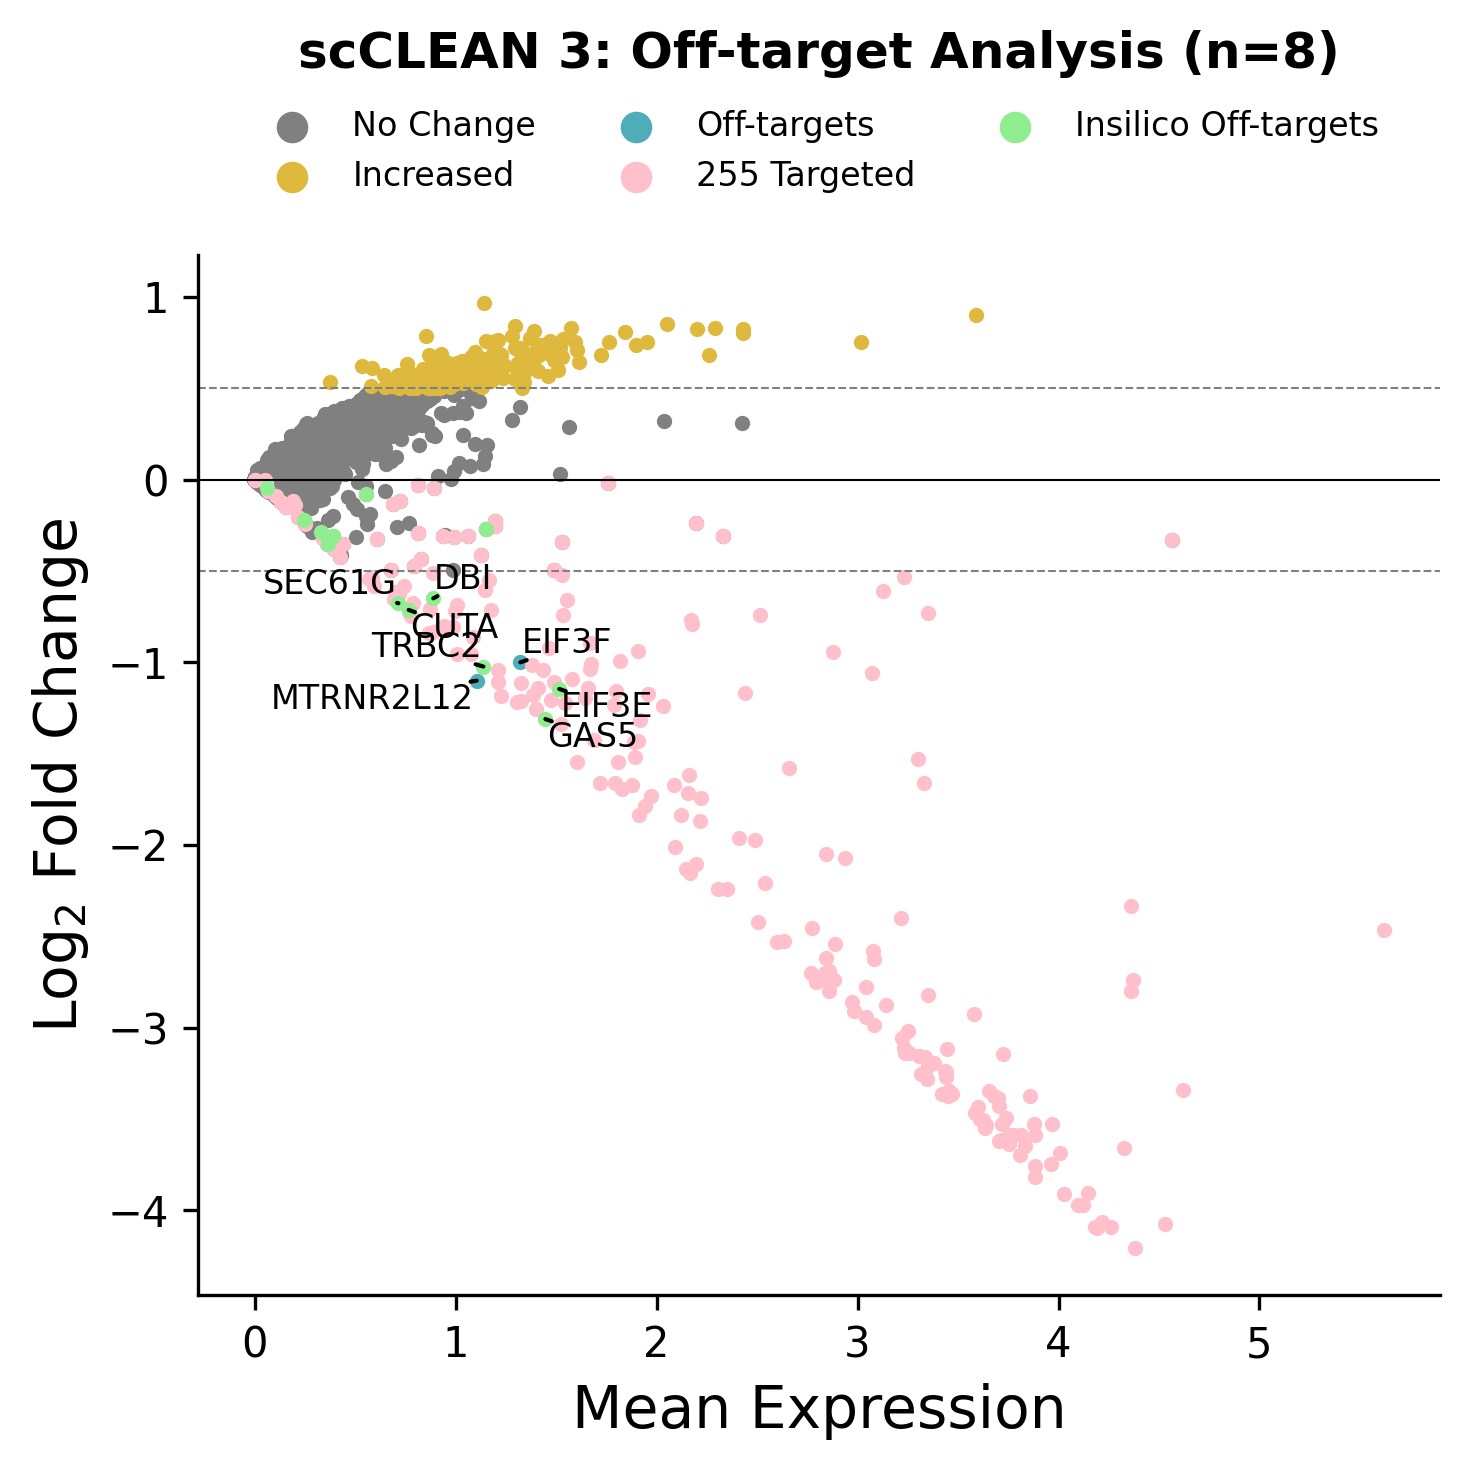

In [336]:
#plot control mean on x-axis, log2FC on y-axis, set threshold, select
from pegasus.plotting.plot_utils import _get_subplot_layouts
fig, ax = _get_subplot_layouts(panel_size=(5, 5), dpi=300)

idx = (exp_combined.Log2FC < 0.5)&(exp_combined.Log2FC >-0.5)
ax.scatter(exp_combined['10x-V3'][idx], exp_combined.Log2FC[idx], s=10, 
           c='grey', marker='o', linewidths=0.5, alpha=1, label="No Change")

idx = exp_combined.Log2FC >= 0.5
ax.scatter(exp_combined['10x-V3'][idx], exp_combined.Log2FC[idx], s=10, 
           c='#DFB93E', marker='o', linewidths=0.5, alpha=1, label="Increased")

idx = (exp_combined.Log2FC <= -0.5)&(~exp_combined.gene.isin(insilico_decreased))&(~exp_combined.gene.isin(scclean_genes))
ax.scatter(exp_combined['10x-V3'][idx], exp_combined.Log2FC[idx], s=10, 
           c='#4EADB9', marker='o', linewidths=0.5, alpha=1, label="Off-targets")

idx = (exp_combined.Log2FC <= 0)&(exp_combined.gene.isin(scclean_genes))
ax.scatter(exp_combined['10x-V3'][idx], exp_combined.Log2FC[idx], s=10, 
           c='pink', marker='o', linewidths=0.5, alpha=1, label="255 Targeted")

idx = (exp_combined.Log2FC <= 0)&(exp_combined.gene.isin(insilico_decreased))
ax.scatter(exp_combined['10x-V3'][idx], exp_combined.Log2FC[idx], s=10, 
           c='lightgreen', marker='o', linewidths=0.5, alpha=1, label="Insilico Off-targets")


ax.set_xlabel(r"Mean Expression", size=14)
ax.set_ylabel(r"Log$_2$ Fold Change", size=14)


legend = ax.legend(
        loc="center",
        bbox_to_anchor=(0.5, 1.1),
        frameon=False,
        fontsize=8,
        ncol=3,
    )
for handle in legend.legendHandles: # adjust legend size
    handle.set_sizes([50.0])

ax.axhline(y = 0, c = 'k', lw = 0.5, ls = '-')
ax.axhline(y = -0.5, c = 'grey', lw = 0.5, ls = '--')
ax.axhline(y = 0.5, c = 'grey', lw = 0.5, ls = '--')

right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)

#######
texts = []
    
idx = np.where((exp_combined.Log2FC < -0.5)&(~exp_combined.gene.isin(scclean_genes)))[0]
posvec = np.argsort(exp_combined.Log2FC[idx])[0:20]
for pos in posvec:
    gid = idx[pos]
    texts.append(ax.text(exp_combined['10x-V3'][gid], exp_combined.Log2FC[gid], exp_combined.gene[gid], fontsize=8))
    
    
from adjustText import adjust_text
adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle='-', color='black', lw=1))

plt.title('scCLEAN 3: Off-target Analysis (n='+str(len(texts))+')', fontweight="bold", size=12, pad=45)
plt.tight_layout()
plt.savefig('PBMC_offtarget_analysis/scCLEAN_rep3_offtarget_gene_selection.png', dpi=300)
plt.show()

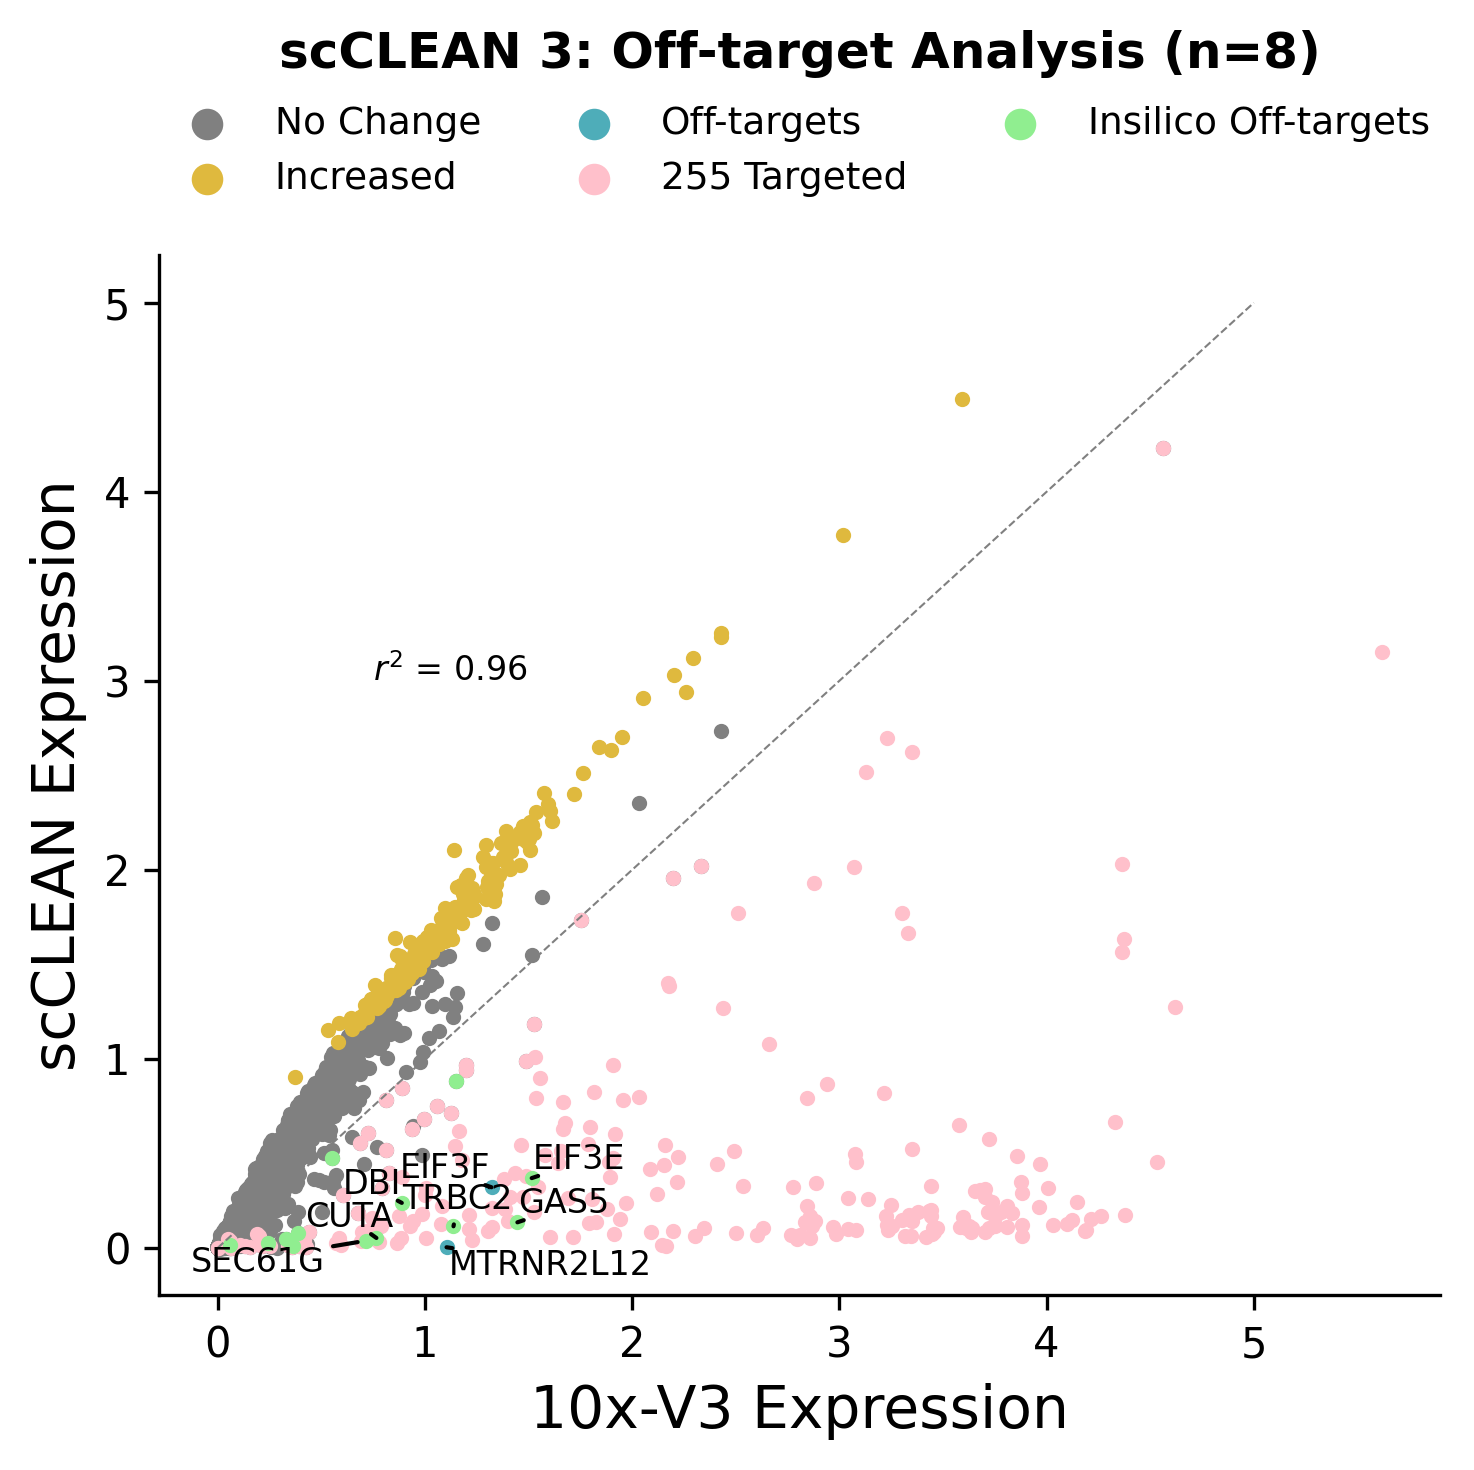

In [337]:
#plot control mean on x-axis, log2FC on y-axis, set threshold, select
from pegasus.plotting.plot_utils import _get_subplot_layouts
fig, ax = _get_subplot_layouts(panel_size=(5, 5), dpi=300)

idx = (exp_combined.Log2FC < 0.5)&(exp_combined.Log2FC >-0.5)
ax.scatter(exp_combined['10x-V3'][idx], exp_combined['scCLEAN'][idx], s=10, 
           c='grey', marker='o', linewidths=0.5, alpha=1, label="No Change")

idx = exp_combined.Log2FC >= 0.5
ax.scatter(exp_combined['10x-V3'][idx], exp_combined['scCLEAN'][idx], s=10, 
           c='#DFB93E', marker='o', linewidths=0.5, alpha=1, label="Increased")

idx = (exp_combined.Log2FC <= -0.5)&(~exp_combined.gene.isin(insilico_decreased))&(~exp_combined.gene.isin(scclean_genes))
ax.scatter(exp_combined['10x-V3'][idx], exp_combined['scCLEAN'][idx], s=10, 
           c='#4EADB9', marker='o', linewidths=0.5, alpha=1, label="Off-targets")

idx = (exp_combined.Log2FC <= 0)&(exp_combined.gene.isin(scclean_genes))
ax.scatter(exp_combined['10x-V3'][idx], exp_combined['scCLEAN'][idx], s=10, 
           c='pink', marker='o', linewidths=0.5, alpha=1, label="255 Targeted")

idx = (exp_combined.Log2FC <= 0)&(exp_combined.gene.isin(insilico_decreased))
ax.scatter(exp_combined['10x-V3'][idx], exp_combined['scCLEAN'][idx], s=10, 
           c='lightgreen', marker='o', linewidths=0.5, alpha=1, label="Insilico Off-targets")


ax.set_xlabel(r"10x-V3 Expression", size=14)
ax.set_ylabel(r"scCLEAN Expression", size=14)


legend = ax.legend(
        loc="center",
        bbox_to_anchor=(0.5, 1.1),
        frameon=False,
        fontsize=9,
        ncol=3,
    )
for handle in legend.legendHandles: # adjust legend size
    handle.set_sizes([50.0])


right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)

ax.plot([0, 5], [0, 5], color='grey', linestyle='dashed', linewidth=0.5)

######
no_255genes = exp_combined[~exp_combined.gene.isin(scclean_genes)]

x= list(no_255genes['10x-V3'])
y= list(no_255genes['scCLEAN'])

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r2 = str(round(r_squared, 2))
plt.text(0.75, 3, "$r^2$ = " + r2, fontsize = 8)

#######
texts = []
    
idx = np.where((exp_combined.Log2FC < -0.5)&(~exp_combined.gene.isin(scclean_genes)))[0]
posvec = np.argsort(exp_combined.Log2FC[idx])[0:20]
for pos in posvec:
    gid = idx[pos]
    texts.append(ax.text(exp_combined['10x-V3'][gid], exp_combined['scCLEAN'][gid], exp_combined.gene[gid], fontsize=8))
    
    
from adjustText import adjust_text
adjust_text(texts, force_text=0.5, arrowprops=dict(arrowstyle='-', color='black', lw=1))

plt.title('scCLEAN 3: Off-target Analysis (n='+str(len(texts))+')', fontweight="bold", size=12, pad=45)
plt.tight_layout()
plt.savefig('PBMC_offtarget_analysis/scCLEAN_rep3_offtarget_correlation_r2.png', dpi=300)
plt.show()